## EMMA step 2: Projecting streamwater samples and potential endmembers into PCA space to select endmembers for EMMA
### -  Tracers selected in EMMA step 1: bivariate plots to ID conservative mixing

###  - MED note that my ealier python code had a mistake in that separate PCAs were performed on the streamwater and EM datasets. We want the same coordinate system to determine their relationships, so this code rectifies that issue. As in EMMALAB, the EM data are projected into the streamwater PCA space.

### - Event-based PCAs: take as function parameters: site, date range, EM1, EM2, EM3

### 

In [22]:
# Set working directory
import os
os.chdir("/home/millieginty/OneDrive/git-repos/EMMA/")

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_event_pca_with_avgEM(
    data,
    site,
    start_date,
    end_date,
    endmember_ids,
    title="Event-Specific PCA"
):
    """
    Generate PCA plot for a specific storm event, following the EMMALAB workflow:
    PCA is fit ONLY on streamwater (mixture) data, then endmembers are projected
    into that PCA space.
    Also plots AvgEMScore: mean PC score for each endmember type.
    """

    # Site-specific tracers
    if site == "Wade":
        tracers = ['Ca_mg_L', 'Si_mg_L', 'Mg_mg_L', 'dD', 'd18O', 'Na_mg_L']
    elif site == "Hungerford":
        tracers = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L', 'dD', 'd18O']
    else:
        raise ValueError("Site not recognized. Use 'Wade' or 'Hungerford'.")

    # Ensure datetime column is datetime type
    data["Date"] = pd.to_datetime(data["Date"], format="%m/%d/%Y", errors="coerce")

    # Subset streamwater (mixture) in date range and site
    stream = data[
        (data["Site"] == site) &
        (data["Type"].isin(["Grab", "Grab/Isco", "Baseflow"])) &
        (data["Date"] >= pd.to_datetime(start_date)) &
        (data["Date"] <= pd.to_datetime(end_date))
    ].copy()

    # Subset endmembers by Sample ID
    endmembers = data[
        (data["Site"] == site) &
        (data["Sample ID"].isin(endmember_ids))
    ].copy()

    # Drop NA for stream tracers
    subset_stream = stream[tracers].dropna().copy()
    subset_stream["Group"] = "Streamwater"
    subset_stream["Type"] = "Streamwater"
    subset_stream["Date"] = stream["Date"]

    # Fill NA for endmembers with mean (per tracer)
    subset_endmembers = endmembers[tracers].copy()
    subset_endmembers = subset_endmembers.fillna(subset_endmembers.mean())
    subset_endmembers["Group"] = "Endmember"
    subset_endmembers["Type"] = endmembers["Type"].values
    subset_endmembers["Date"] = endmembers["Date"].values

    # -----------------------
    # EMMALAB PCA logic
    # -----------------------
    scaler = StandardScaler()
    scaled_stream = scaler.fit_transform(subset_stream[tracers])

    pca = PCA(n_components=2)
    stream_pca_result = pca.fit_transform(scaled_stream)
    subset_stream["PC1"] = stream_pca_result[:, 0]
    subset_stream["PC2"] = stream_pca_result[:, 1]

    scaled_endmembers = scaler.transform(subset_endmembers[tracers])
    endmember_pca_result = pca.transform(scaled_endmembers)
    subset_endmembers["PC1"] = endmember_pca_result[:, 0]
    subset_endmembers["PC2"] = endmember_pca_result[:, 1]

    # Combine
    combined = pd.concat([subset_stream, subset_endmembers], ignore_index=True)

    # -----------------------
    # Compute AvgEMScore + SD
    # -----------------------
    stats_em = (
        subset_endmembers.groupby("Type")[["PC1", "PC2"]]
        .agg(['mean', 'std'])
    )
    stats_em.columns = ['PC1_mean', 'PC1_std', 'PC2_mean', 'PC2_std']
    stats_em = stats_em.reset_index()
    stats_em["Group"] = "AvgEMScore"

    # -----------------------
    # Plotting
    # -----------------------
    fig, ax = plt.subplots(figsize=(10, 6))

    # Streamwater points
    sw = combined[combined["Group"] == "Streamwater"]
    ax.scatter(sw["PC1"], sw["PC2"], marker='+', c='blue', alpha=0.5, label='Streamwater')

    # Endmember markers/colors
    endmember_markers = {
        'Rain': 'o', 'Snow': 's', 'Snowmelt lysimeter': '^', 'Precip': '*',
        'Soil water lysimeter dry': '<', 'Soil water lysimeter wet': '>',
        'Groundwater': 'D', 'Baseflow': 'P'
    }
    colors = ['#d7191c', '#fdae61', '#abdda4', '#2b83ba',
              '#2ca25f', '#636363', '#8856a7', '#d95f0e']

    # Plot mean + error bars (instead of individual endmembers)
    for (etype, color) in zip(endmember_markers.keys(), colors):
        em_stat = stats_em[stats_em["Type"] == etype]
        if not em_stat.empty:
            ax.errorbar(
                em_stat["PC1_mean"], em_stat["PC2_mean"],
                xerr=em_stat["PC1_std"], yerr=em_stat["PC2_std"],
                fmt=endmember_markers[etype],  # marker style
                color=color, ecolor=color,
                elinewidth=1.5, capsize=4,
                markersize=12, markeredgecolor='black',
                label=f"{etype} mean ±1 SD"
            )

    # Variance explained
    pc1_var = pca.explained_variance_ratio_[0] * 100
    pc2_var = pca.explained_variance_ratio_[1] * 100
    ax.set_xlabel(f"PC1 ({pc1_var:.1f}%)")
    ax.set_ylabel(f"PC2 ({pc2_var:.1f}%)")

    ax.set_title(title)

    # --- Save plot as 'output/site_title.jpg' ---
    # Sanitize filename: replace spaces and parentheses
    save_event_name = title.replace(" ", "_").replace("(", "").replace(")", "").replace(":", "")
    filename = f"{site}_{save_event_name}.jpg"
    output_path = os.path.join("output", filename)

    fig.savefig(output_path, dpi=300)
    print(f"Saved plot to: {output_path}")
    
    ax.legend(bbox_to_anchor=(1.02, 1.02), loc="upper left")
    plt.tight_layout()
    plt.show()

Saved plot to: output/Wade_D._2-D_Mixing_space_for_Wade_Feb._ROS_Feb_14–20,_2023.jpg


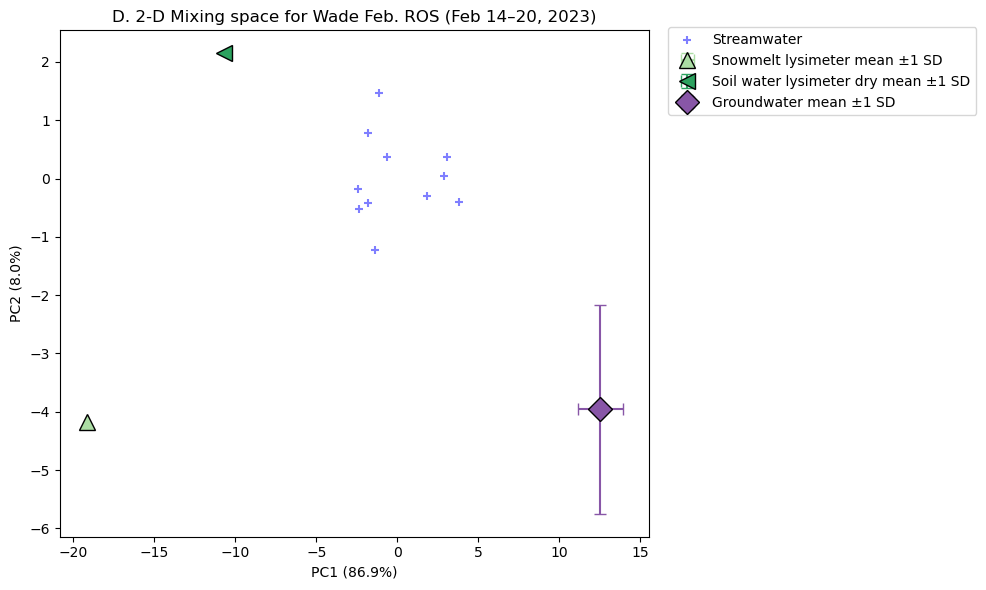

Saved plot to: output/Wade_E._2-D_Mixing_space_for_Wade_Mar._thermal_Mar_21–26,_2023.jpg


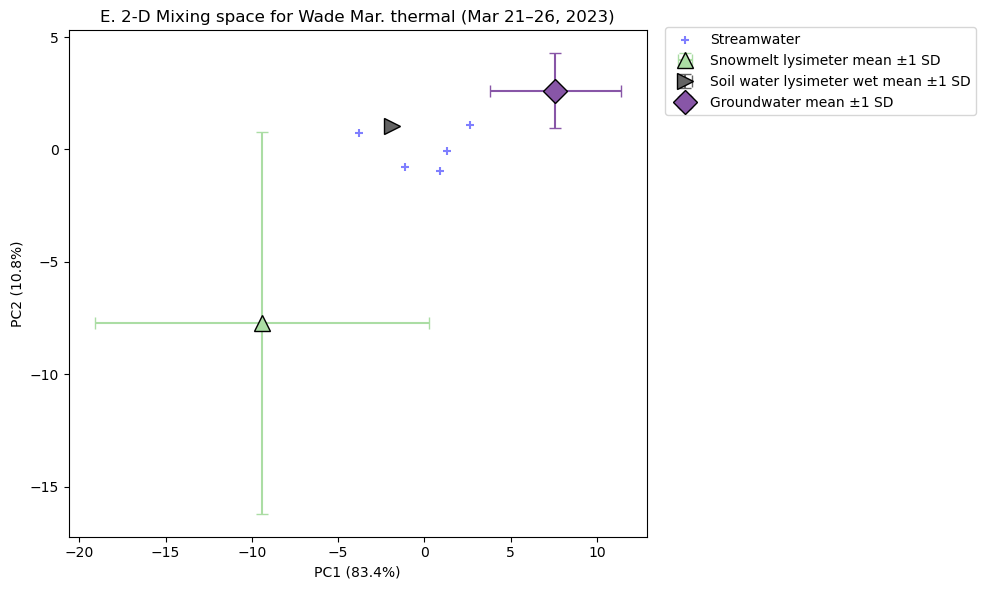

Saved plot to: output/Wade_F._2-D_Mixing_space_for_Wade_spring_freshet_Mar_30_–_April_15,_2023.jpg


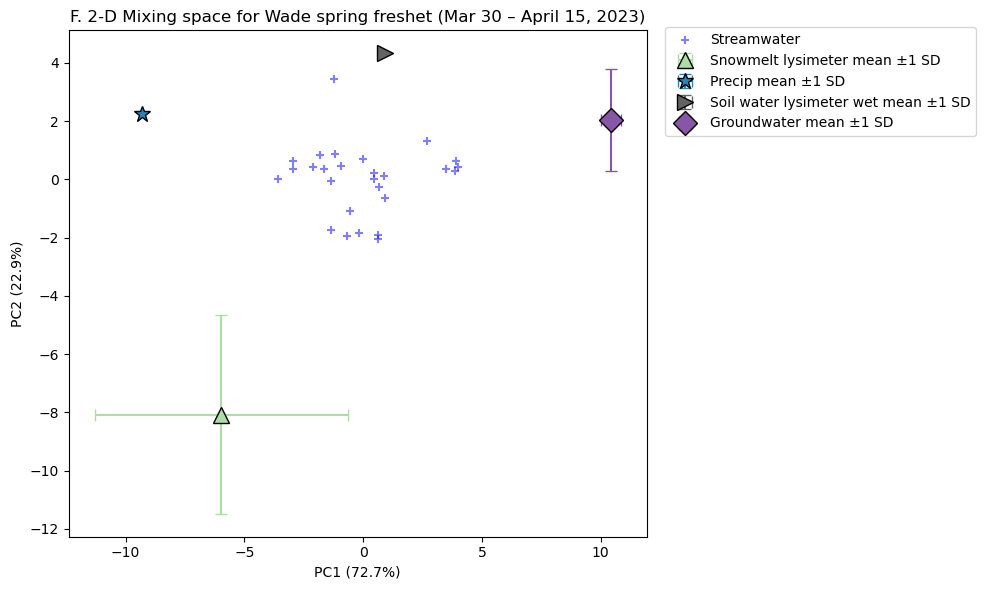

Saved plot to: output/Hungerford_A._2-D_Mixing_space_for__Hungerford_Feb._ROS_Feb_08–12,_2023.jpg


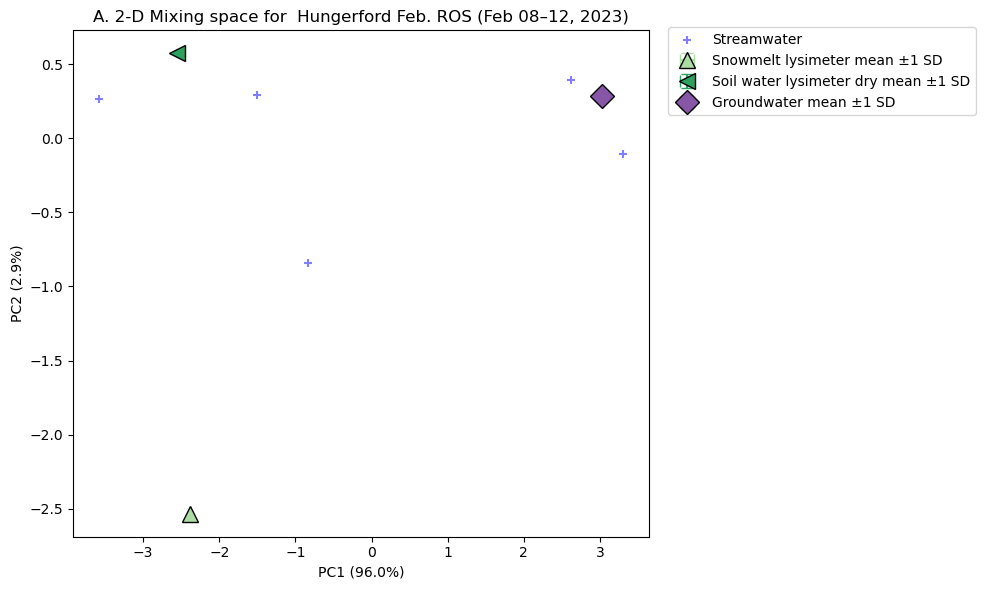

Saved plot to: output/Hungerford_B._2-D_Mixing_space_for_Hungerford_Mar._thermal_Mar_21–26,_2023.jpg


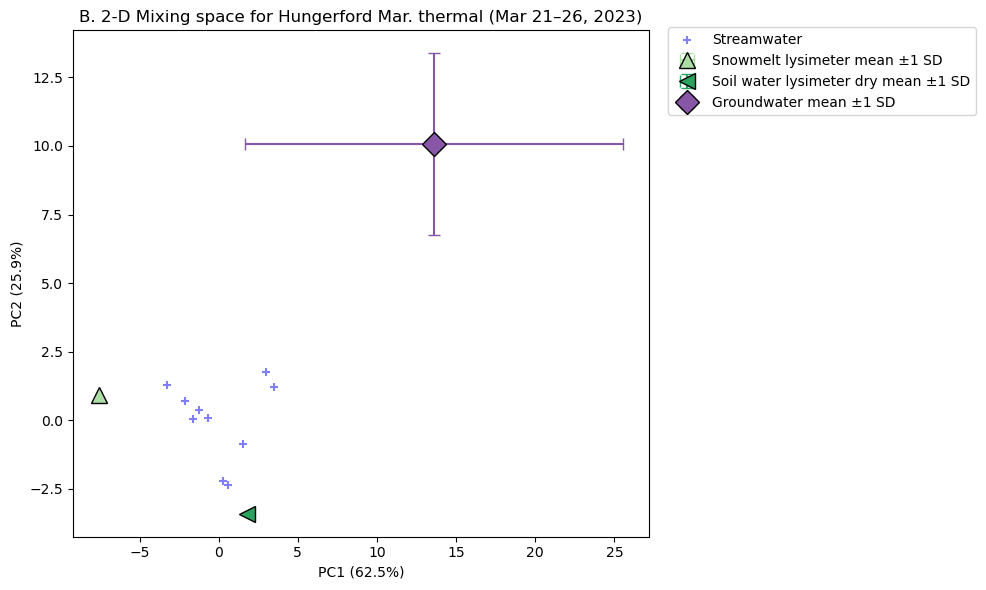

Saved plot to: output/Hungerford_C._2-D_Mixing_space_for_Hungerford_spring_freshet_Mar_30_–_April_03,_2023.jpg


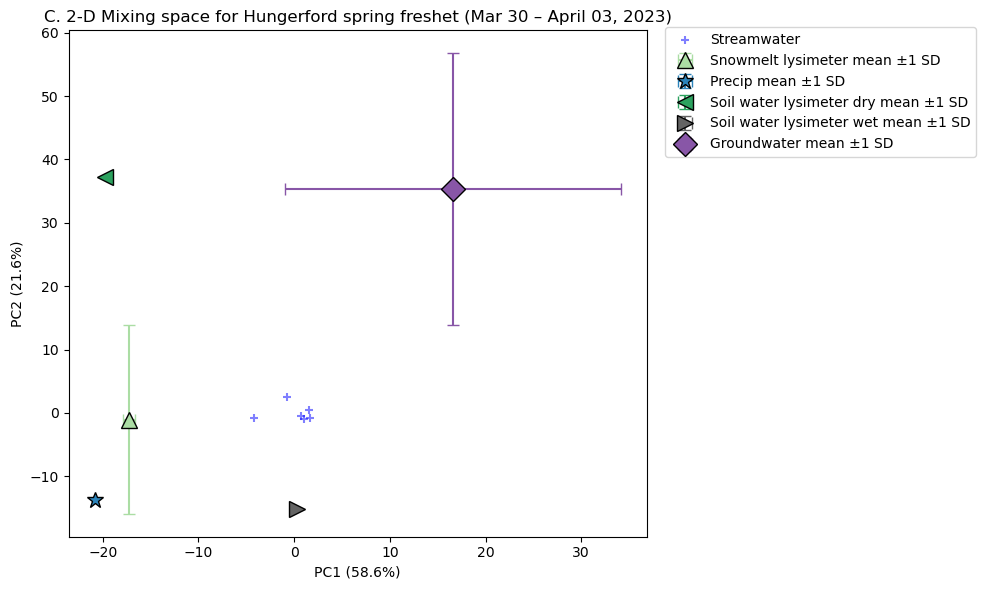

In [24]:
# Load the full RI23 dataset
df = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-toc-joined.csv")

####################
# Wade RI23 events #
####################

# Wade February ROS event
# Endmembers: 
    # RI23-5018 Groundwater Bear Pond 03/10/23
    # RI23-5006 Groundwater High Pond 03/01/23 (could be 03/10/23, doesn't really matter)
    # RI23-5000 Soil water lysimeter dry 02/15/23
    # RI23-5005 Snowmelt lysimeter 2/15
    # RI23-1032 Baseflow (pre-event 2/17, really post event..)

plot_event_pca_with_avgEM(
    data=df,
    site="Wade",
    start_date="2023-02-14",
    end_date="2023-02-20",
    endmember_ids=["RI23-5018", "RI23-5006", "RI23-5000", "RI23-5005"],  # Removed RI23-1032 for now
    title="D. 2-D Mixing space for Wade Feb. ROS (Feb 14–20, 2023)"
)

# Wade March thermal event
# Endmembers: 
    # RI23-5018 Groundwater Bear Pond 03/10/23
    # RI23-5006 Groundwater High Pond 03/01/23 (could be 03/10/23, doesn't really matter)
    # RI23-5000 Soil water lysimeter dry 02/15/23 (removed)
    # RI23-5005 Snowmelt lysimeter 2/15 (removed)
    # RI23-5009 Soil water lysimeter dry 3/16 (removed)
    # RI23-1063 Snowmelt lysimeter 3/28
    # RI23-1034 Baseflow 3/22 (labeled as GW)
    # RI23-5011 Soil water lysimeter wet 4/12

plot_event_pca_with_avgEM(
    data=df,
    site="Wade",
    start_date="2023-03-21",
    end_date="2023-03-26",
    endmember_ids=["RI23-5018", "RI23-5006", "RI23-5005", "RI23-1063", "RI23-1034", "RI23-5011"],  
    title="E. 2-D Mixing space for Wade Mar. thermal (Mar 21–26, 2023)"
)

# Wade spring freshet
# Endmembers: 
    # RI23-5018 Groundwater Bear Pond 03/10/23
    # RI23-5006 Groundwater High Pond 03/01/23 (could be 03/10/23, doesn't really matter)
    # RI23-5010 Precip 04/10
    # RI23-1098 Snowmelt lysimeter 4/11
    # RI23-5011 Soil water lysimeter wet 4/12
    # RI23-5012 Snowmelt lysimeter 4/12
    # RI23-1063 Snowmelt lysimeter 3/28

plot_event_pca_with_avgEM(
    data=df,
    site="Wade",
    start_date="2023-03-30",
    end_date="2023-04-15",
    endmember_ids=["RI23-5018", "RI23-5006", "RI23-5010", "RI23-5011", "RI23-1063", "RI23-5005"],  
    title="F. 2-D Mixing space for Wade spring freshet (Mar 30 – April 15, 2023)"
)

##########################
# Hungerford RI23 events #
##########################

# Hungerford Feb ROS event
# Endmembers: 
    # RI23-5008 Groundwater (Mark's well) 03/16/23 (removed)
    # RI23-1001 Baseflow 02/09/23 (labeled GW)
    # RI23-5003 Soil water lysimter dry 02/15/23
    # RI23-5002 Snowmelt lysimeter 02/15/23

plot_event_pca_with_avgEM(
    data=df,
    site="Hungerford",
    start_date="2023-02-08",
    end_date="2023-02-12",
    endmember_ids=["RI23-1001", "RI23-5003", "RI23-5002"],  
    title="A. 2-D Mixing space for  Hungerford Feb. ROS (Feb 08–12, 2023)"
)

# Hungerford March thermal event
# Endmembers: 
    # RI23-5008 Groundwater (Mark's well) 03/16/23
    # RI23-1035 Baseflow 03/31/23
    # RI23-5007 Soil water lysimeter dry 03/16/23
    # RI23-1061 Snowmelt lysimeter 03/28/23

plot_event_pca_with_avgEM(
    data=df,
    site="Hungerford",
    start_date="2023-03-21",
    end_date="2023-03-26",
    endmember_ids=["RI23-1001", "RI23-5008", "RI23-5007", "RI23-1061"],  #"RI23-1035", removed for now
    title="B. 2-D Mixing space for Hungerford Mar. thermal (Mar 21–26, 2023)"
)

# Hungerford spring freshet
# Endmembers: 
    # RI23-5008 Groundwater (Mark's well) 03/16/23
    # RI23-1085 Baseflow 03/31/23
    # RI23-5013 Soil water lysimeter wet 04/12/23
    # RI23-5014 Soil water lysimeter dry 04/12/23
    # RI23-5016 Precip 04/13/23
    # RI23-5017 Snowmelt lysimeter 04/12/23
    # RI23-1061 Snowmelt lysimeter 03/28/23
    # RI23-1001 Baseflow 02/09/23

plot_event_pca_with_avgEM(
    data=df,
    site="Hungerford",
    start_date="2023-03-30",
    end_date="2023-04-04",
    endmember_ids=["RI23-1001", "RI23-5008", "RI23-5013", "RI23-5014", "RI23-5016", "RI23-5017", "RI23-1061"],  #"RI23-1085", removed for now
    title="C. 2-D Mixing space for Hungerford spring freshet (Mar 30 – April 03, 2023)"
)